In [37]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
import warnings
from sklearn.metrics import silhouette_score

# For Hopkins
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

In [38]:
warnings.simplefilter('ignore')

In [39]:
# Reading the csv file
org_df = pd.read_csv('Country-data.csv')

In [40]:
org_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [41]:
#Checking the information associated with the dataframe
org_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


### Inference: The provided data is in correct format and no null values are present

In [42]:
# Removing country name from features as we do not need that column while perforing clustering
df = org_df.iloc[:,1:]

In [43]:
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [44]:
# As Health, imports & exports are % of gdp, let convert them in actual numbers
df['exports'] = df.apply(lambda x: x['exports'] * x['gdpp'] / 100, axis = 1)
df['health'] = df.apply(lambda x: x['health'] * x['gdpp'] / 100, axis = 1)
df['imports'] = df.apply(lambda x: x['imports'] * x['gdpp'] / 100, axis = 1)

In [45]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [46]:
#Calculating the Hopkins statistic
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

### Hopkins Score: Cluster Tendency

In [47]:
# Checking Hopkins Score
hopkins(df)

0.9704440715208517

### Inference: Hopkins Statistics shows that the dataset has good cluster tendency, thus we can go ahead for bifurcating data in clusters

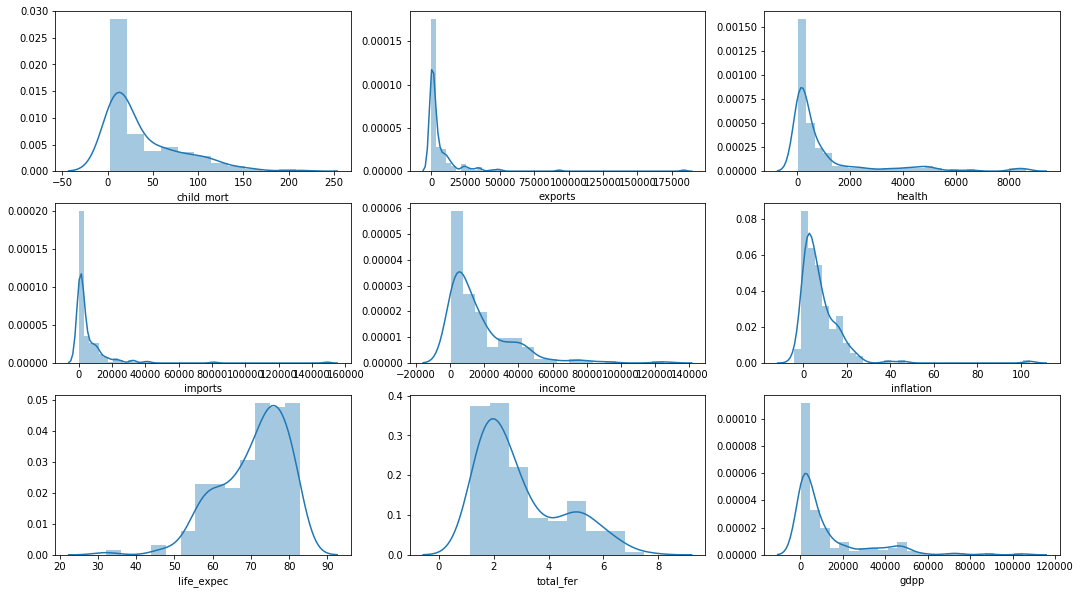

In [48]:
## Checking data distribution
plt.figure(figsize = (18,10))
cols = list(df.columns)
for num in enumerate(cols, start = 1):
        plt.subplot(3,3,num[0])
        sns.distplot(df[num[1]])
plt.show()

### Inference: The above plot shows us that data is not normally distributed for child_mort, life_expec, total_fer, gdpp, income

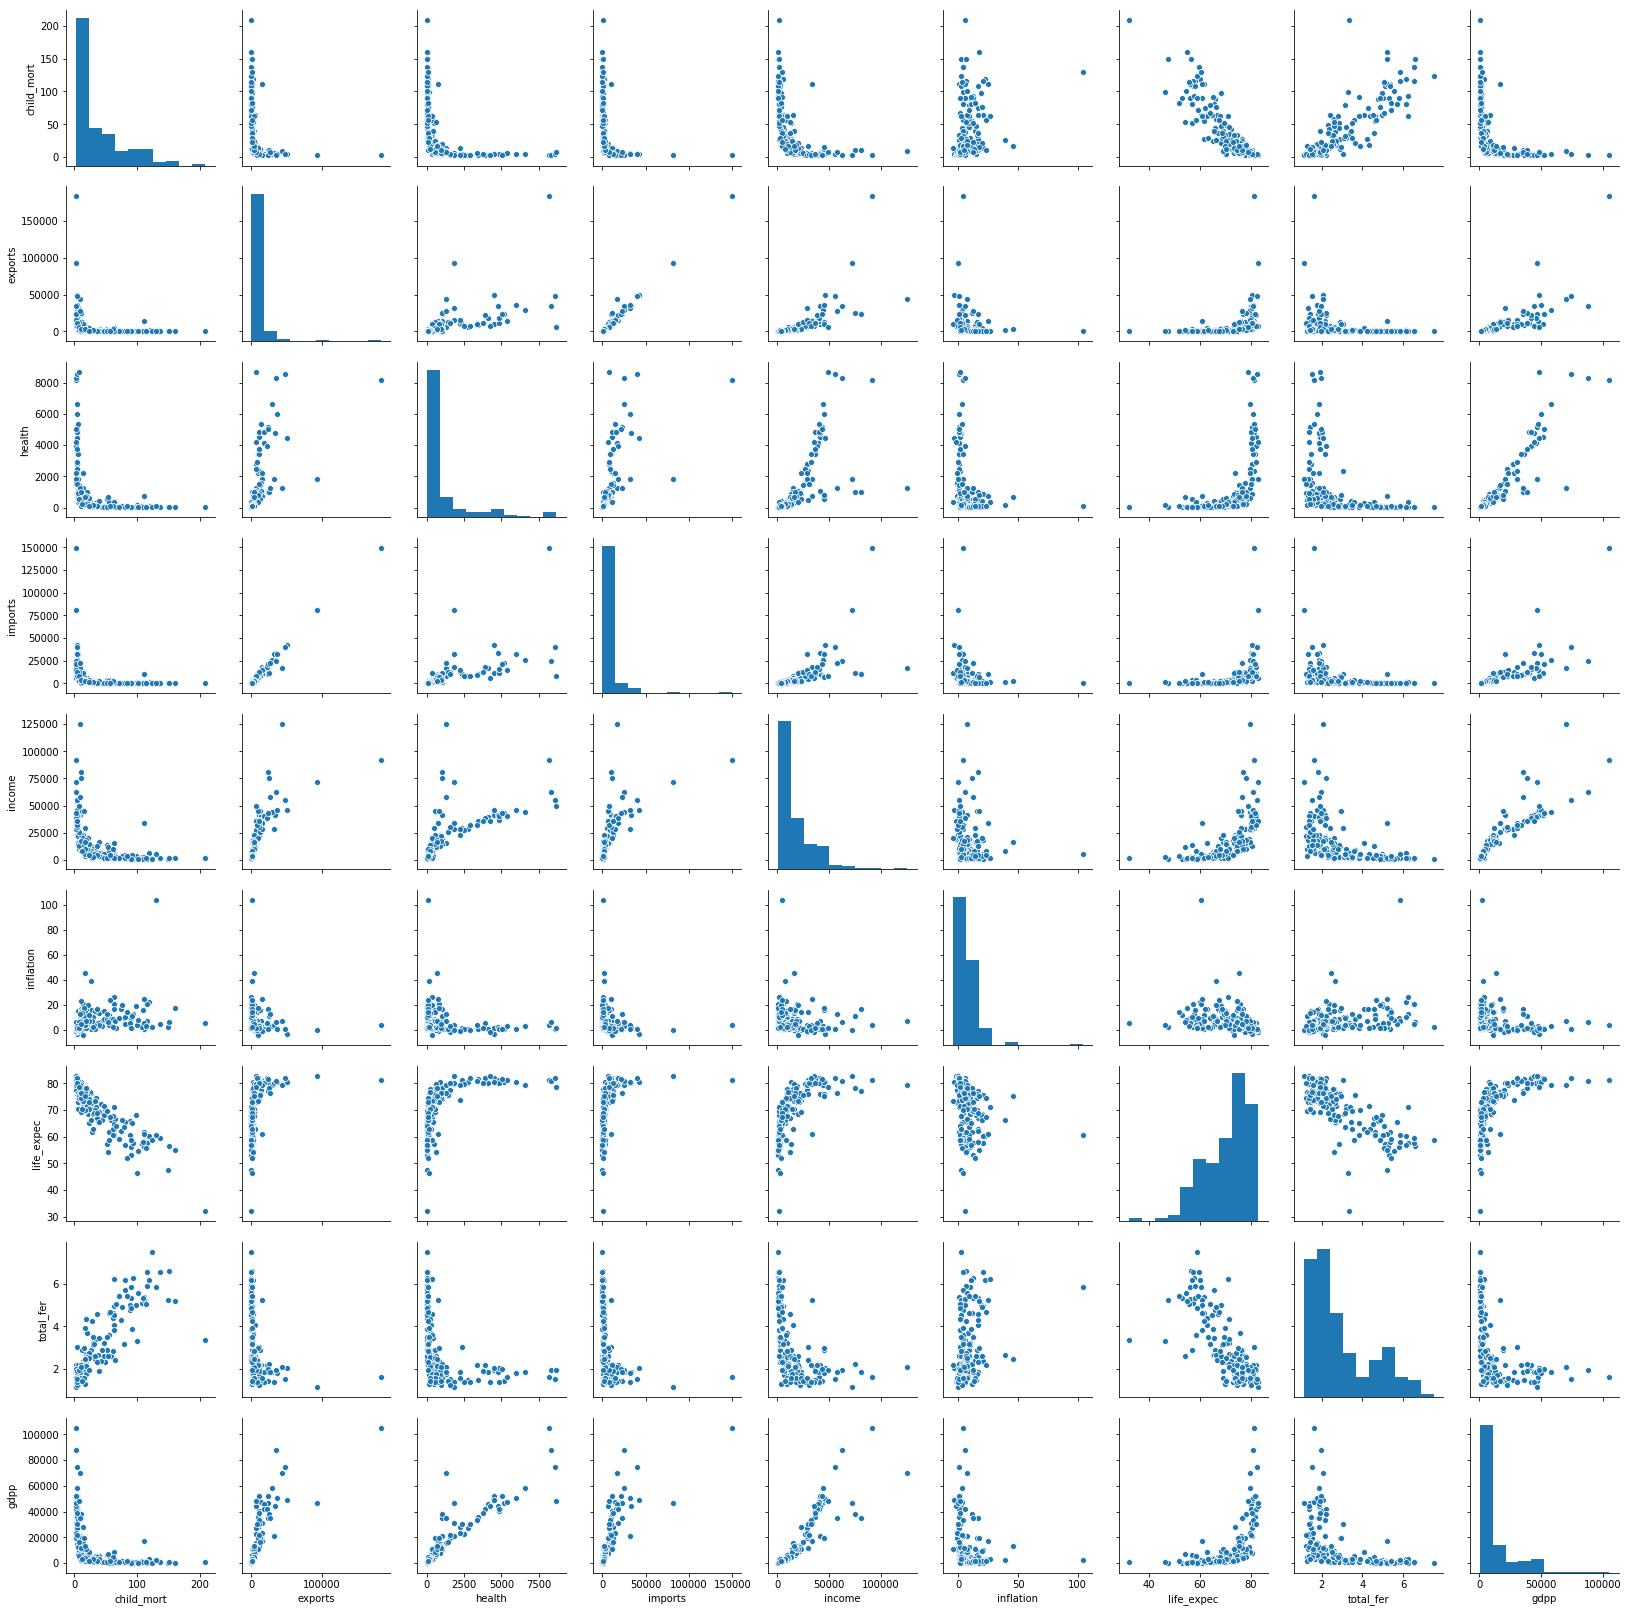

In [49]:
#PLotting scatterplot to see the relation between the variables
sns.pairplot(df)
plt.show()

### Inferences:
1. With the increase in income, gdpp is also increasing
2. As the child mortality is increasing total_fer is also increasing
3. As the child_mort is increasing life_expec is decreasing.
4. As the income is increasing expenditure on health is increasing
5. As the import is increasing export is also increasing.
6. With the increase in gdpp, expenditure on health is also increasing.

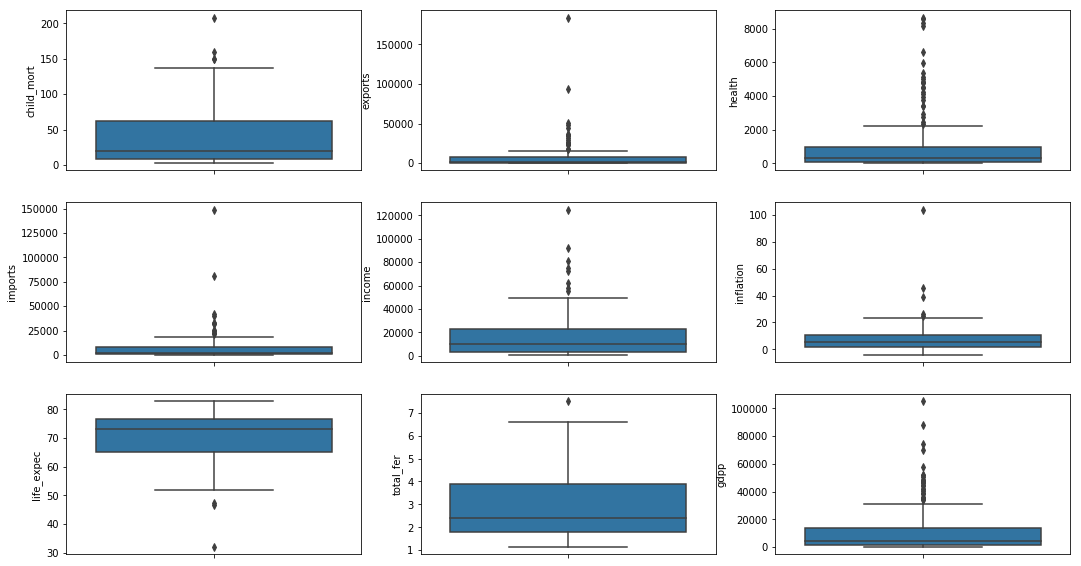

In [50]:
# Plotting boxplots to check the outliers as above description shows high variance
def box_plot():
    cols = list(df.columns)
    plt.figure(figsize = (18,10))
    for num in enumerate(cols, start = 1):
        plt.subplot(3,3,num[0])
        sns.boxplot(y = df[num[1]])
    plt.show()

box_plot()

### Inference: There are some outliers at upper end of following features : gdpp, exports, imports, health, income, inflation which needs to checked and treated

In [51]:
# As there is no outlier at lower whisker for following features : gdpp, exports, imports, health, income, inflation, let's see and treat the outliers at upper whisker 
#end for previous given columns (softcapping the outliers)
gdpp_q = df.gdpp.quantile(.98)
df['gdpp'][df.gdpp> (gdpp_q)] = gdpp_q

export_q = df.exports.quantile(.98)
df['exports'][df.exports> (export_q)] = export_q

health_q = df.health.quantile(.98)
df['health'][df.health> (health_q)] = health_q

import_q = df.imports.quantile(.98)
df['imports'][df.imports> (import_q)] = import_q

income_q = df.income.quantile(.98)
df['income'][df.income> (income_q)] = income_q

inflation_q = df.inflation.quantile(.98)
df['inflation'][df.inflation> (inflation_q)] = inflation_q

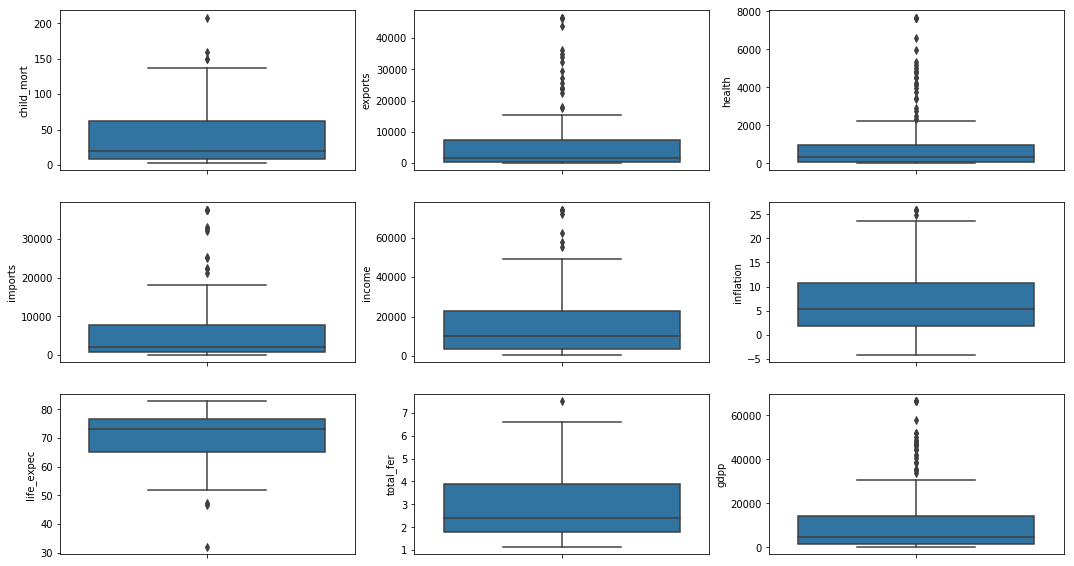

In [52]:
#Let's plot the boxplot again to see the outliers after treatment
box_plot()

### Inference: After performing soft capping on outliers, they are still present but they are in the range and no extreme outlier is present as compared to previous plot

### Not treated outliers of child_mort and life_expec as both have negative correlation and they can be helpful for identifying the countries in dire need of aid

## Performing Scaling

In [53]:
# Using Standard Scaler to scale the data
scaled = StandardScaler()
scaled_df = scaled.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df)
scaled_df.head()

,0,1,2,3,4,5,6,7,8
0,1.291532,-0.607005,-0.578451,-0.650202,-0.870777,0.341512,-1.619092,1.902882,-0.721872
1,-0.538949,-0.500881,-0.447266,-0.439715,-0.390399,-0.385041,0.647866,-0.859973,-0.508719
2,-0.272833,-0.445629,-0.494818,-0.510783,-0.218918,1.319056,0.670423,-0.038404,-0.486422
3,2.007808,-0.398254,-0.544381,-0.496997,-0.623082,2.243760,-1.179234,2.128151,-0.542467
4,-0.695634,-0.071888,-0.175718,0.189295,0.139056,-0.832715,0.704258,-0.541946,-0.019981


### Hierarchical Clustering

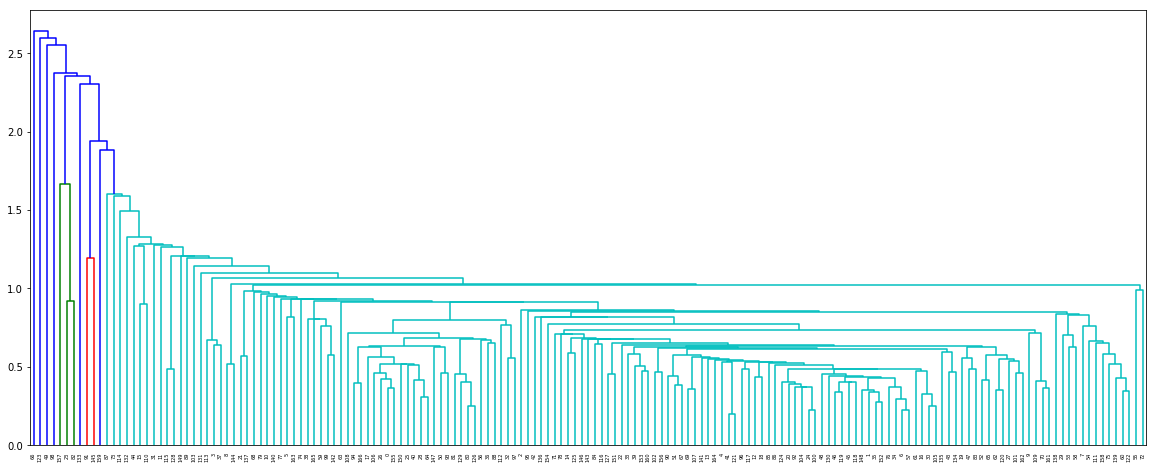

In [54]:
# Let's start with hierarcal clustering to identify the good representation of clusters forming in the dataset
# Single Linkage
plt.figure(figsize = (20,8))
single_merg = linkage(scaled_df, method = 'single', metric = 'euclidean')
dendrogram(single_merg)
plt.show()

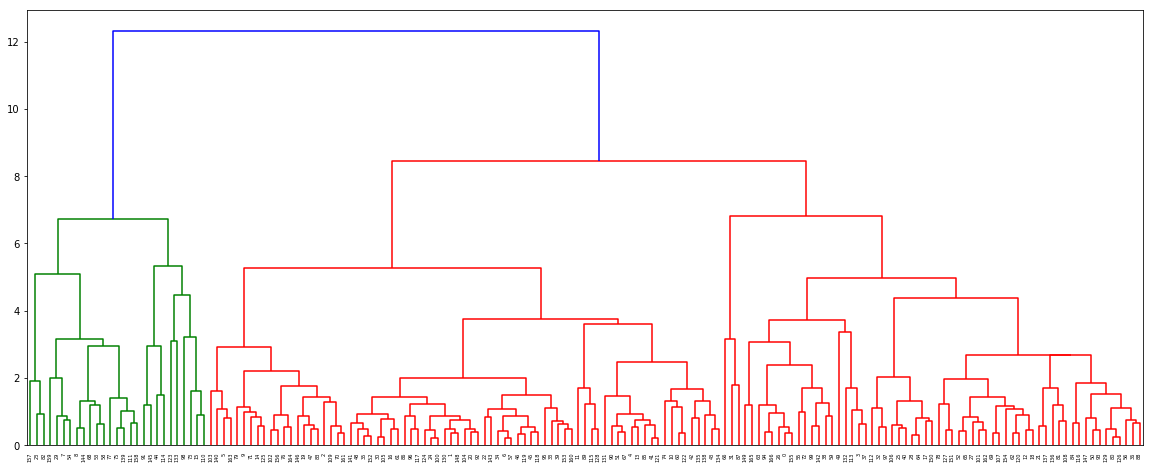

In [55]:
# Complete Linkage
plt.figure(figsize = (20,8))
merging = linkage(scaled_df, method = 'complete', metric = 'euclidean')
dendrogram(merging)
plt.show()

In [56]:
# Cutting the tree consisering clusters as 3 using complete linkage
hier_clus_label = cut_tree(merging, n_clusters = 3)
hier_clus_label = hier_clus_label.reshape(-1)

In [57]:
# Assigning cluster id to original dataframe
org_df['hier_cluster'] = hier_clus_label

In [58]:
# Let's see how many data points are there in each cluster
org_df.hier_cluster.value_counts()

1    77
0    63
2    27
Name: hier_cluster, dtype: int64

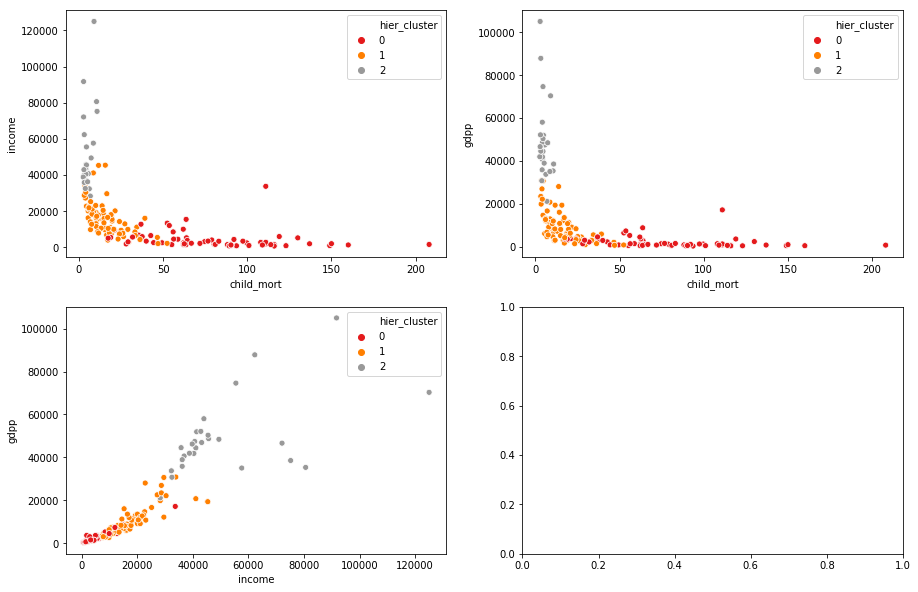

In [59]:
#Plotting scatter plot to see the how cluster is contructed accroding to 3 features: child_mort, income, gdpp
fig, axs = plt.subplots(2,2, figsize = (15,10))
sns.scatterplot(x = 'child_mort', y = 'income',hue = 'hier_cluster',  data = org_df, ax = axs[0][0], palette = 'Set1')
sns.scatterplot(x = 'child_mort', y = 'gdpp',hue = 'hier_cluster',  data = org_df, ax = axs[0][1], palette = 'Set1')
sns.scatterplot(x = 'income', y = 'gdpp',hue = 'hier_cluster',  data = org_df, ax = axs[1][0], palette = 'Set1')
plt.show()

### Inference: Above plots shows clear distinction of clusters with some overlapping

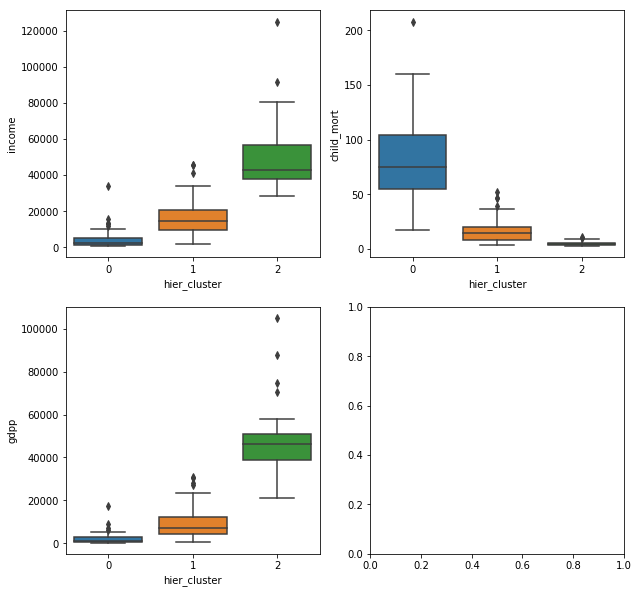

In [60]:
#Let see the boxplot with cluster with above 3 parameters
fig, axs = plt.subplots(2,2, figsize = (10,10))
sns.boxplot(x = org_df['hier_cluster'],y = org_df['income'], ax = axs[0][0])
sns.boxplot(x = org_df['hier_cluster'],y = org_df['child_mort'], ax = axs[0][1])
sns.boxplot(x = org_df['hier_cluster'],y = org_df['gdpp'], ax = axs[1][0])
plt.show()

### Inference:
1. Cluster 0 is the group of countries in which gdpp and income is lower then rest but child morality is high.
2. Cluster 2 as shown belongs to countries which have lowest child morality rate but high income and gdpp.
3. Cluster 1 belongs to countries which belong to medium group with medium income, gdpp and child morality rate

### K - Means Clustering

In [61]:
## Applying K Means algorithm for 2 to 9 clusters
sil_score= []
ssd = []
for num in range(2,10):
    kmeans = KMeans(n_clusters = num, random_state = 10)
    kmeans.fit(scaled_df)
    ssd.append([num,kmeans.inertia_])
    sil_score= silhouette_score(scaled_df, kmeans.labels_)
    print('Silhouette score at {0} clusters : {1}'.format(num,sil_score))

Silhouette score at 2 clusters : 0.4766273670619959
Silhouette score at 3 clusters : 0.4007120183680722
Silhouette score at 4 clusters : 0.382056731197606
Silhouette score at 5 clusters : 0.34592327094274283
Silhouette score at 6 clusters : 0.3264503882093174
Silhouette score at 7 clusters : 0.3174736134791277
Silhouette score at 8 clusters : 0.3166829535958183
Silhouette score at 9 clusters : 0.31389872529055585


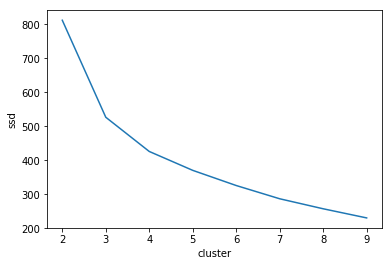

In [62]:
# Plotting Elbow Curve
el_df = pd.DataFrame(ssd,columns = ['cluster','ssd'])
sns.lineplot(x = el_df['cluster'], y = el_df['ssd'])
plt.show()

### Inference: Above silhouette score and elbow curve shows that 3 clusters are the optimum number of cluster

In [63]:
# Performing K Means clustering again with 3 clusters
kmeans = KMeans(n_clusters = 3, random_state = 10)
kmeans.fit(scaled_df)
labels = kmeans.labels_

In [64]:
# Asigning K-Means generated cluster id to original data frame
org_df['cluster'] = labels
org_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,hier_cluster,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1,0


In [65]:
# Let's see how many data oints are there in each cluster
org_df.cluster.value_counts()

0    89
2    48
1    30
Name: cluster, dtype: int64

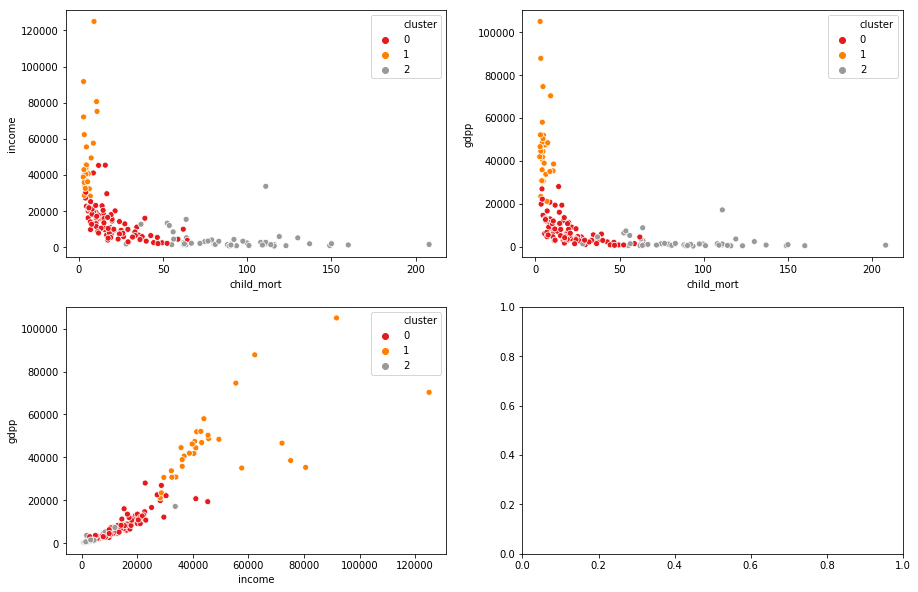

In [66]:
#Plotting scatter plot to see the how cluster is contructed accroding to 3 features: child_mort, income, gdpp
fig, axs = plt.subplots(2,2, figsize = (15,10))
sns.scatterplot(x = 'child_mort', y = 'income',hue = 'cluster',  data = org_df, ax = axs[0][0], palette = 'Set1')
sns.scatterplot(x = 'child_mort', y = 'gdpp',hue = 'cluster',  data = org_df, ax = axs[0][1], palette = 'Set1')
sns.scatterplot(x = 'income', y = 'gdpp',hue = 'cluster',  data = org_df, ax = axs[1][0], palette = 'Set1')
plt.show()

### Inference: Above plots shows clear distinction of clusters with some overlapping

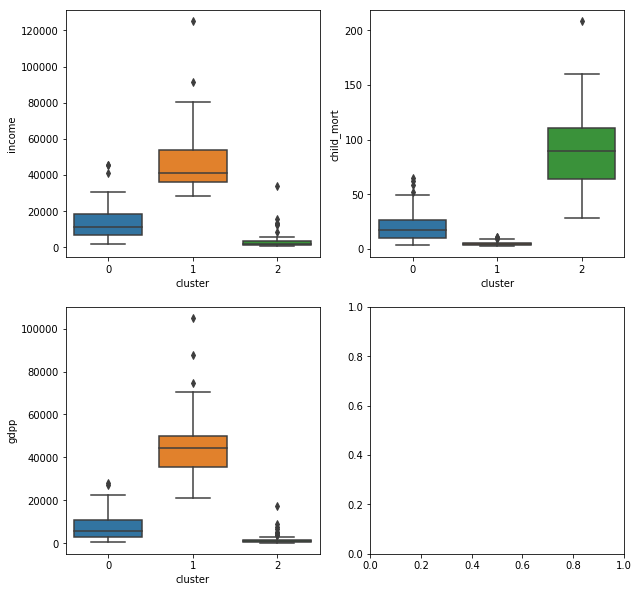

In [67]:
#Let see the boxplot with cluster with above 3 parameters
fig, axs = plt.subplots(2,2, figsize = (10,10))
sns.boxplot(x = org_df['cluster'],y = org_df['income'], ax = axs[0][0])
sns.boxplot(x = org_df['cluster'],y = org_df['child_mort'], ax = axs[0][1])
sns.boxplot(x = org_df['cluster'],y = org_df['gdpp'], ax = axs[1][0])
plt.show()


### Inference: 
1. Cluster 2 is the group of countries in which gdpp and income is lower then rest but child morality is high.
2. Cluster 1 as shown belongs to countries which have lowest child morality rate but high income and gdpp.
3. Cluster 0 belongs to countries which belong to medium group with medium income, gdpp and child morality rate.

### Countries in cluster 2 are the ones which are in dire need of attention according to K Means

In [68]:
# Lets' see the countries name which are in cluster 2
df_count_aide = org_df[org_df['cluster'] == 2].sort_values(by = ['income','gdpp','child_mort'], ascending = [True,True,False])

In [69]:
df_count_aide.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,hier_cluster,cluster
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334,0,2
88,Liberia,89.3,19.10,11.80,92.6,700,5.47,60.8,5.02,327,0,2
26,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231,0,2
112,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348,0,2
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446,0,2
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419,0,2
94,Malawi,90.5,22.80,6.59,34.9,1030,12.10,53.1,5.31,459,0,2
63,Guinea,109.0,30.30,4.93,43.2,1190,16.10,58.0,5.34,648,0,2
150,Togo,90.3,40.20,7.65,57.3,1210,1.18,58.7,4.87,488,0,2
132,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399,0,2


### Countries in cluster 0 are the ones which are in dire need of attention according to Hierarchical Clustering

In [70]:
# Lets' see the countries name which are in cluster 0
df_count_aide_hier = org_df[org_df['hier_cluster'] == 0].sort_values(by = ['income','gdpp','child_mort'], ascending = [True,True,False])

In [71]:
df_count_aide_hier.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,hier_cluster,cluster
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334,0,2
88,Liberia,89.3,19.10,11.80,92.6,700,5.47,60.8,5.02,327,0,2
26,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231,0,2
112,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348,0,2
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446,0,2
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419,0,2
94,Malawi,90.5,22.80,6.59,34.9,1030,12.10,53.1,5.31,459,0,2
63,Guinea,109.0,30.30,4.93,43.2,1190,16.10,58.0,5.34,648,0,2
150,Togo,90.3,40.20,7.65,57.3,1210,1.18,58.7,4.87,488,0,2
132,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399,0,2


### Inference: Top 10 results of both the clustering method are same

### Result: Top 10 countries which are in dire need of aid are:
1. Congo, Dem. Rep.
2. Liberia
3. Burundi
4. Niger
5. Central African Republic
6. Mozambique
7. Malawi
8. Guinea
9. Togo
10. Sierra Leone